In [2]:
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)


In [5]:
!pwd

/home/seongha/LT-ML/notebooks


# 1. Class Distribution

VOC-MLT

In [4]:
path_csv = '../data/voc/files/VOC2007'
trainval_csv = os.path.join(path_csv, 'classification_trainval.csv')

hi = pd.read_csv(trainval_csv)
hi=hi.iloc[:,1:]
print(hi.columns)
class_num = dict()
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)

nums=[]
from collections import defaultdict
cls_ind = defaultdict(list)

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  # di[col_name] = val.value_counts().to_dict()
  M = hi[hi[col_name].isin([1.0])].sum(axis=0)
  # print(M)
  cls_ind[col_name].extend(hi.index[hi[col_name].isin([1.0])].to_list())
  nums.append(M[col_name])
  class_num[col_name] = M[col_name]
class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
cls_ind = {k: v for k, v in sorted(cls_ind.items(), key=lambda item: len(item[1]), reverse=True)} #sorted

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')


In [5]:
class_di.keys()

dict_keys(['person', 'car', 'chair', 'dog', 'sofa', 'cat', 'bird', 'horse', 'tvmonitor', 'pottedplant', 'diningtable', 'train', 'bottle', 'bicycle', 'motorbike', 'aeroplane', 'bus', 'boat', 'cow', 'sheep'])

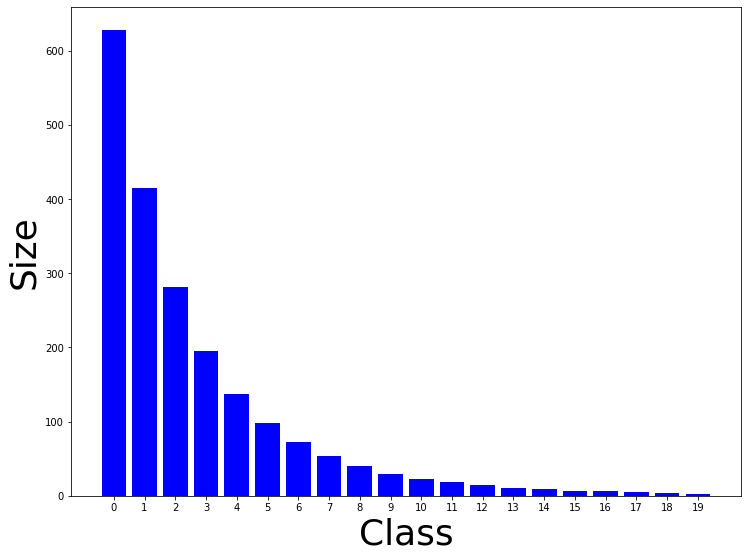

In [6]:
from scipy.stats import pareto
num_classes = len(class_di.items())

alpha = 6
ma = 628
mi = 1
rv = pareto(alpha)
# classes = class_num.keys()
classes = [str(int(i)) for i in range(num_classes)]
classes_x = np.linspace(pareto.ppf(0.0, alpha), pareto.ppf(0.99, alpha), num_classes)
dist = rv.pdf(classes_x) * (ma-mi) / alpha + mi
dist  = dist.astype(int)

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.bar( classes, dist, color='blue')
# ax.bar_label(ax.containers[0], label_type='edge', color='red', rotation=0, fontsize=10, padding=3)
# ax.set_xticklabels(classes,rotation=90, fontsize=10)
plt.xlabel('Class', size=36)
plt.ylabel("Size", size=36)
# plt.show()
figure = plt.gcf()
figure.set_size_inches(12, 9)
plt.savefig('./dist_num{:d}_b{:d}_max{:d}-min{:d}.pdf'.format(num_classes, alpha, ma, mi), dpi = 300)


cOCO-MLT

In [48]:
path_csv = '../data/coco'

from collections import defaultdict, Counter
class_num = defaultdict(int)
with open(path_csv + '/data/train_anno.json') as f:
  adj = np.zeros((80,80))
  import json
  train = json.load(f)
  print(len(train), train[0])

  li = []
  gt_labels = np.zeros((len(train),80))
  img_id2idx = dict()
  idx2img_id = []
  for i,each in enumerate(train):
    li += each['labels']
    gt_labels[i, each['labels']] = 1
    for l in each['labels']:
      class_num[l] += 1

  nums = gt_labels.sum(axis=0)
  adj = []
  for i,col in enumerate(gt_labels.T):
    if i in [34]:
      print(i)
      selected = gt_labels[np.isin(col, [1.0]), :]
      nonzero_cnt = (selected != 0).sum(1)
      cnter = Counter(nonzero_cnt)
      print(cnter)
    cond_prob = gt_labels[np.isin(col,[1.0]),:].sum(axis=0)
    cond_prob[i] = 0
    adj.append(cond_prob)
    # print(adj[-1])
  nums = nums.tolist()
  nums.sort()
  nums.reverse()
  # nums = reversed(nums)
  print(max(nums), min(nums))
  di={'adj': np.asarray(adj), "nums": np.asarray(nums)}
  class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
print(class_di.keys(), class_di.values())

82081 {'file_name': 'COCO_train2014_000000057870.jpg', 'labels': [12, 77, 51, 22, 27]}
34
Counter({1: 1234, 2: 407, 3: 116, 4: 27, 5: 8, 8: 3, 7: 2, 6: 1})
45174.0 128.0
dict_keys([49, 22, 18, 27, 26, 13, 14, 36, 74, 2, 8, 12, 21, 57, 75, 24, 23, 41, 51, 28, 62, 72, 20, 16, 76, 68, 7, 32, 77, 58, 61, 42, 73, 44, 67, 65, 70, 9, 0, 10, 59, 50, 53, 11, 17, 37, 47, 5, 4, 34, 78, 52, 54, 64, 40, 3, 30, 33, 66, 39, 25, 15, 79, 45, 46, 63, 31, 19, 1, 60, 56, 43, 29, 38, 71, 55, 6, 48, 69, 35]) dict_values([45174, 8950, 8606, 8378, 6518, 5968, 5028, 4861, 4321, 3924, 3844, 3734, 3322, 3291, 3191, 3170, 3159, 3097, 3084, 3041, 2986, 2893, 2818, 2791, 2749, 2667, 2539, 2537, 2530, 2511, 2493, 2475, 2464, 2442, 2368, 2343, 2317, 2287, 2243, 2241, 2209, 2202, 2180, 2098, 2080, 2068, 2003, 1884, 1804, 1798, 1771, 1671, 1645, 1631, 1625, 1618, 1518, 1511, 1510, 1471, 1389, 1340, 1324, 1290, 1216, 1214, 1205, 1186, 1171, 1170, 1105, 1089, 1062, 821, 700, 673, 668, 481, 151, 128])


80


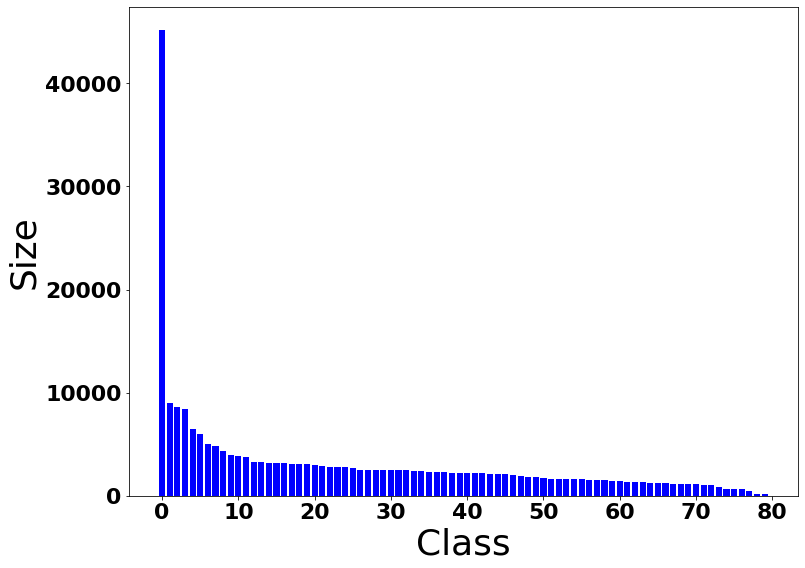

In [26]:
num_classes = len(nums)
print(num_classes)

font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.bar( classes, nums, color='blue')
# ax.bar_label(ax.containers[0], label_type='edge', color='red', rotation=0, fontsize=36, padding=3)
# ax.set_xticklabels(classes,rotation=0, fontsize=10)
plt.xlabel('Class', size=36)
plt.ylabel("Size", size=36)
# plt.show()
figure = plt.gcf()
figure.set_size_inches(12, 9)
plt.savefig('../figures/coco_distribution.png', dpi = 300)

# 2. Classwise AP

In [17]:
model = resnet18(pretrained=True)
from models import *
backbone = BaseResnet(model, 80)
# backbone2 = BaseResnet(model, 20)
# sa = TRANSCONV_clf(backbone, 20, 300, 'voc_lt_adj.pkl')
# te2 = TRANSFORMER_ENCODER_2_clf(backbone, 20, 1, 16)
# gcn = GCN_clf(backbone, 20, 300, None, 'voc_lt_adj.pkl')

path = '/home/seongha/LT-ML/checkpoint/coco/coco_LT(1)_label_count_1-4-4-0_resnet18_base_best.pth.tar'

di = torch.load(path)
print(di['best_score'])
print(di.keys())
backbone.load_state_dict(di['state_dict'])

{'mAP': tensor(38.9650), 'OF1': 0.2537588013210293, 'CF1': 0.25796767041568475}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])


<All keys matched successfully>

In [13]:
c

[dataset] Done!
[annotation] Done!
[json] Done!


VOC

In [ ]:
path_csv = '../data/voc/files/VOC2007'
test_csv = os.path.join(path_csv, 'classification_test.csv')

test_df = pd.read_csv(test_csv)
test_df=test_df.iloc[:,1:]
print(test_df.columns)
test_df=test_df.replace(0,1)
# test_df=test_df.replace(-1,0)

from collections import defaultdict
cls_ind = defaultdict(list)

for col_name, val in test_df.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  # di[col_name] = val.value_counts().to_dict()
  # print(M)
  cls_ind[col_name].extend(test_df.index[test_df[col_name].isin([1.0])].to_list())

cls_ind = {k: v for k, v in sorted(cls_ind.items(), key=lambda item: len(item[1]), reverse=True)} #sorted

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')


COCO

In [12]:
len(nums)

80

In [14]:
from util import AveragePrecisionMeter
AP = AveragePrecisionMeter(difficult_examples=False)

Evaluate

In [18]:
for i, (input, target) in tqdm(enumerate(test_loader)):
  img, path, inp = input
  target[target == 0] = 1
  target[target == -1] = 0
  feat_Var = torch.autograd.Variable(img).float().detach()
  
  # output = model(feat_Var, None).detach()
  output = backbone(feat_Var, None).detach()
  # print(output.requires_grad, target.requires_grad)
  AP.add(output, target)
map = 100 * AP.value().mean()
print(100 * AP.value())

1255it [09:13,  2.27it/s]


tensor([44.8806, 18.7181,  4.2505, 26.0276,  1.8891,  2.0793, 55.0725, 29.3584,
        21.6527, 13.7635, 34.6959, 50.7117,  4.5387,  9.8258, 10.3550, 42.5709,
        39.2878, 19.0187, 29.4253, 10.1510, 57.6950, 11.8762, 13.9065, 42.1499,
         4.6982, 33.9326, 10.8716, 15.9627, 32.3844, 19.4244, 61.4208, 29.5272,
         3.1157,  3.6808, 75.4917,  0.1942,  5.2710, 19.7860, 15.4992, 16.0211,
        15.0432,  3.9782, 21.1419,  8.8907, 30.8293,  1.9951, 32.1277, 21.3268,
        20.2985, 83.6436, 46.0174,  5.8537, 20.1276,  5.9066, 20.2521, 12.6364,
        54.7259, 21.3757,  3.1344,  6.6266,  3.5166,  3.2945,  3.5212, 31.7686,
        15.5602, 11.4469, 40.4510,  2.9287, 17.3079,  0.1819, 36.1461,  2.6347,
        30.3691, 31.7924, 28.6856, 21.0613, 17.1495, 20.7845,  3.5991, 73.5261])


In [46]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']#voc
label_li = [i for i in range(80)] #coco

ap_li = [75.4188, 76.3768, 66.3551, 79.1177, 45.1441, 62.4649, 83.6811, 85.9619,
        58.1541, 48.6313, 67.8912, 79.3836, 79.2103, 69.3254, 88.5846, 50.0462,
        26.8350, 57.0530, 75.6681, 71.1823]#FC
ap_li2 = [77.9105, 76.8534, 71.2095, 80.9140, 45.2674, 63.6200, 84.0961, 86.4019,
        59.8740, 52.9656, 68.0257, 80.5327, 79.3948, 71.0906, 88.7570, 49.5162,
        33.0532, 55.2915, 76.8210, 70.2609]#Transformer
ap_li_gcn = [44.9041, 51.7194, 41.8896, 52.5085, 31.0836, 42.8794, 75.6171, 61.9646,
        39.8540, 26.9209, 45.8847, 50.5602, 48.6032, 48.8849, 78.4147, 37.8425,
        15.7030, 46.4849, 45.6828, 53.3943]#gcn
ap_li_tc = [52.6595, 59.2412, 48.0880, 60.5390, 34.5672, 49.0508, 77.6743, 70.0045,
        42.0592, 32.3638, 49.0484, 57.0762, 55.9363, 55.3863, 81.9262, 41.5481,
        18.1342, 48.6349, 52.5640, 58.6664]#TC

ap_li_base_coco = [44.8806, 18.7181,  4.2505, 26.0276,  1.8891,  2.0793, 55.0725, 29.3584,
        21.6527, 13.7635, 34.6959, 50.7117,  4.5387,  9.8258, 10.3550, 42.5709,
        39.2878, 19.0187, 29.4253, 10.1510, 57.6950, 11.8762, 13.9065, 42.1499,
         4.6982, 33.9326, 10.8716, 15.9627, 32.3844, 19.4244, 61.4208, 29.5272,
         3.1157,  3.6808, 75.4917,  0.1942,  5.2710, 19.7860, 15.4992, 16.0211,
        15.0432,  3.9782, 21.1419,  8.8907, 30.8293,  1.9951, 32.1277, 21.3268,
        20.2985, 83.6436, 46.0174,  5.8537, 20.1276,  5.9066, 20.2521, 12.6364,
        54.7259, 21.3757,  3.1344,  6.6266,  3.5166,  3.2945,  3.5212, 31.7686,
        15.5602, 11.4469, 40.4510,  2.9287, 17.3079,  0.1819, 36.1461,  2.6347,
        30.3691, 31.7924, 28.6856, 21.0613, 17.1495, 20.7845,  3.5991, 73.5261]

Sorted_Ap = []
for k, v in class_di.items():
       idx = label_li.index(k)
       print("{}, {}, {}".format(k, v, ap_li_base_coco[idx]))
       Sorted_Ap.append( ap_li_base_coco[idx])
ap_li_base_coco.sort()
ap_li_base_coco.reverse()
ap_li_base_coco

49, 45174, 83.6436
22, 8950, 13.9065
18, 8606, 29.4253
27, 8378, 15.9627
26, 6518, 10.8716
13, 5968, 9.8258
14, 5028, 10.355
36, 4861, 5.271
74, 4321, 28.6856
2, 3924, 4.2505
8, 3844, 21.6527
12, 3734, 4.5387
21, 3322, 11.8762
57, 3291, 21.3757
75, 3191, 21.0613
24, 3170, 4.6982
23, 3159, 42.1499
41, 3097, 3.9782
51, 3084, 5.8537
28, 3041, 32.3844
62, 2986, 3.5212
72, 2893, 30.3691
20, 2818, 57.695
16, 2791, 39.2878
76, 2749, 17.1495
68, 2667, 17.3079
7, 2539, 29.3584
32, 2537, 3.1157
77, 2530, 20.7845
58, 2511, 3.1344
61, 2493, 3.2945
42, 2475, 21.1419
73, 2464, 31.7924
44, 2442, 30.8293
67, 2368, 2.9287
65, 2343, 11.4469
70, 2317, 36.1461
9, 2287, 13.7635
0, 2243, 44.8806
10, 2241, 34.6959
59, 2209, 6.6266
50, 2202, 46.0174
53, 2180, 5.9066
11, 2098, 50.7117
17, 2080, 19.0187
37, 2068, 19.786
47, 2003, 21.3268
5, 1884, 2.0793
4, 1804, 1.8891
34, 1798, 75.4917
78, 1771, 3.5991
52, 1671, 20.1276
54, 1645, 20.2521
64, 1631, 15.5602
40, 1625, 15.0432
3, 1618, 26.0276
30, 1518, 61.4208
33

[83.6436,
 75.4917,
 73.5261,
 61.4208,
 57.695,
 55.0725,
 54.7259,
 50.7117,
 46.0174,
 44.8806,
 42.5709,
 42.1499,
 40.451,
 39.2878,
 36.1461,
 34.6959,
 33.9326,
 32.3844,
 32.1277,
 31.7924,
 31.7686,
 30.8293,
 30.3691,
 29.5272,
 29.4253,
 29.3584,
 28.6856,
 26.0276,
 21.6527,
 21.3757,
 21.3268,
 21.1419,
 21.0613,
 20.7845,
 20.2985,
 20.2521,
 20.1276,
 19.786,
 19.4244,
 19.0187,
 18.7181,
 17.3079,
 17.1495,
 16.0211,
 15.9627,
 15.5602,
 15.4992,
 15.0432,
 13.9065,
 13.7635,
 12.6364,
 11.8762,
 11.4469,
 10.8716,
 10.355,
 10.151,
 9.8258,
 8.8907,
 6.6266,
 5.9066,
 5.8537,
 5.271,
 4.6982,
 4.5387,
 4.2505,
 3.9782,
 3.6808,
 3.5991,
 3.5212,
 3.5166,
 3.2945,
 3.1344,
 3.1157,
 2.9287,
 2.6347,
 2.0793,
 1.9951,
 1.8891,
 0.1942,
 0.1819]

/tmp/ipykernel_79669/1179216661.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes,rotation=0, fontsize=10)


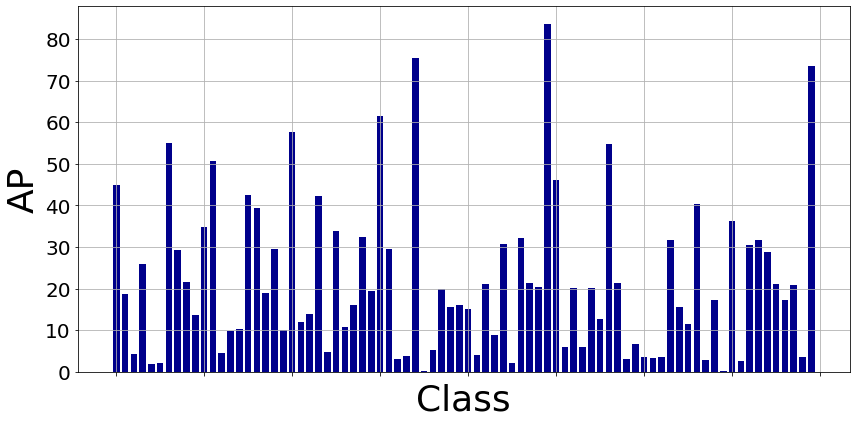

In [39]:
## mAP histogram class-wise

fig, ax = plt.subplots(1, 1, figsize=(12,6))
classes = class_di.keys()
ax.bar( classes, Sorted_Ap, width=0.75, color='darkblue') # metric must be here
ax.grid()
ax.tick_params(labelsize=20)
# ax.bar_label(ax.containers[0], label_type='edge', color='brown', rotation=0, fontsize=20, padding=3)
classes = ['Head'] + [ "" for _ in range(78)] + ["Tail"]

ax.set_xticklabels(classes,rotation=0, fontsize=10)

plt.xlabel('Class', fontsize=36)
plt.ylabel("AP", fontsize=36)
plt.tight_layout()
# plt.show()
# figure = plt.gcf()
# figure.set_size_inches(12, 6)

plt.savefig('../figures/COCO_AP{}.png'.format("_resnet18"), dpi = 600)


# 3. HEATMAP

In [8]:
from models import *
model = resnet101(pretrained=True)
backbone = BaseResnet(model, 20)
sa = TRANSCONV_clf(backbone, 20, 300, '/home/seongha/LT-ML/data/voc/voc_adj.pkl')
te = TRANSFORMER_ENCODER_2_clf(backbone, 20, 1, 16)
p3 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_sa_best.pth.tar'
p4='/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_transformer_encoder-1-16-0_resnet101_transformer_encoder_best.pth.tar'
p5 ='/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_finetune-4-4-0_resnet101_sa_best.pth.tar'

di = torch.load(p5)
sa.load_state_dict(di['state_dict'])
# te.load_state_dict(di['state_dict'])
print(di['best_score'])

count nonzero: 204 shape (20, 20)
{'mAP': tensor(90.2152), 'OF1': 0.8298832684824902, 'CF1': 0.8127624131016865}


In [9]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

mapper=dict()
for i, label in enumerate(label_li):
  idx = list(class_di.keys()).index(label)
  mapper[i] = idx
print(mapper)
map = np.zeros((20,20))
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
print(sa.inp.shape)
print(sa.tc2.lin_query)
print(sa.tc2.lin_value)
for i in range(20):
  
  query = sa.tc2.lin_query.forward(sa.inp[i,:])
  # query = query.reshape((1,-1))
  # query = np.array(query.detach())

  for j in range(20):
    key = sa.tc2.lin_key.forward(sa.inp[j,:])
    map[mapper[i],mapper[j]] = round(float(cos(query, key).detach()), 3)
    # 
    # key = key.reshape((1,-1))
    # key = np.array(key.detach())
    # print(key.shape)
    # map[mapper[i], mapper[j]] = cka.linear_CKA(query, key)

{0: 15, 1: 13, 2: 6, 3: 17, 4: 12, 5: 16, 6: 1, 7: 5, 8: 2, 9: 18, 10: 10, 11: 3, 12: 7, 13: 14, 14: 0, 15: 9, 16: 19, 17: 4, 18: 11, 19: 8}
torch.Size([20, 2048])
Linear(2048, 2048, bias=True)
Linear(2048, 2048, bias=True)


In [10]:
class_di.keys()

dict_keys(['person', 'car', 'chair', 'dog', 'sofa', 'cat', 'bird', 'horse', 'tvmonitor', 'pottedplant', 'diningtable', 'train', 'bottle', 'bicycle', 'motorbike', 'aeroplane', 'bus', 'boat', 'cow', 'sheep'])

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


FileNotFoundError: [Errno 2] No such file or directory: './figures/heatmap.pdf'

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


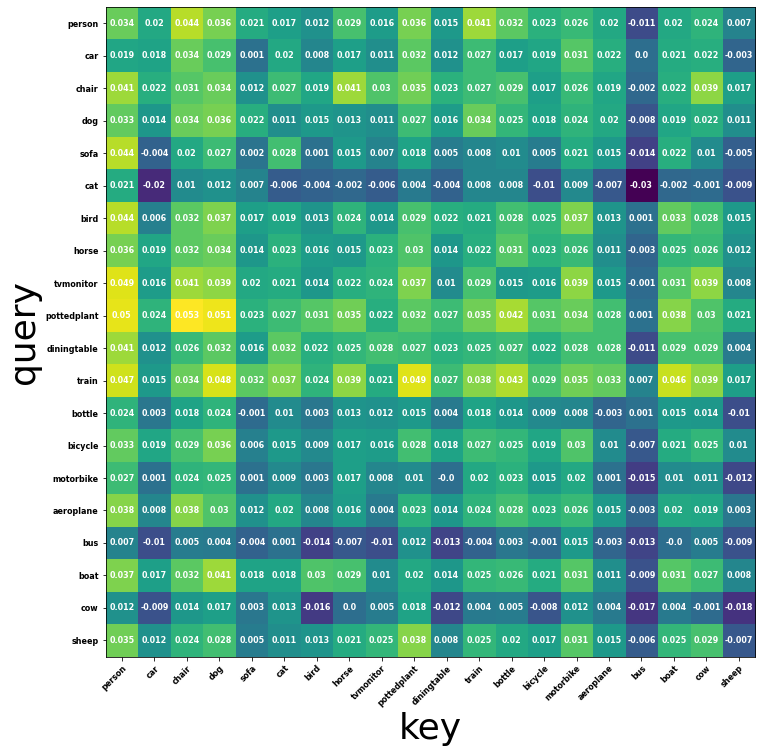

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 8}
import matplotlib
matplotlib.rc('font', **font)

li = list(class_di.keys())
  
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(map)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(li)), labels=li)
ax.set_yticks(np.arange(len(li)), labels=li)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(li)):
    for j in range(len(li)):
        text = ax.text(j, i, map[i, j],
                       ha="center", va="center", color="w")

ax.set_title("")
fig.tight_layout()
plt.ylabel("query", size=36)
plt.xlabel("key", size=36)
# plt.show()
plt.savefig("../figures/heatmap.pdf", dpi=300)

# 4. Classwise Acc

In [40]:
from models import *
model = resnet101(pretrained=True)

backbone = BaseResnet(model, 20)
backbone2 = BaseResnet(model, 20)
sa = TRANSCONV_clf(backbone, 20, 300, 'voc_lt_adj.pkl')
te2 = TRANSFORMER_ENCODER_2_clf(backbone, 20, 1, 16)
gcn = GCN_clf(backbone, 20, 300, None, 'voc_lt_adj.pkl')
se = SE(backbone, 20)
# gcn = GCN_clf(backbone, 20)
##LT
p1= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-1-16-0_resnet101_base_best.pth.tar'#freezed
p2 = 'checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_gcn_best.pth.tar'
p3 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_sa_best.pth.tar'
p4='/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_transformer_encoder-1-16-0_resnet101_transformer_encoder_best.pth.tar'##freeze
p5 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_se_best.pth.tar'
##uniform
path = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-16-1-2_resnet101_base_best.pth.tar'##finetune
path2='/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_base-16-1-1_resnet101_base_best.pth.tar'##freeze

path3= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_freeze-4-4-0_resnet101_sa_best.pth.tar'#freeze
path4 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-2-1-1_resnet101_transformer_encoder_best.pth.tar'

models = []
for path, model in zip([p1, p2, p3, p4, p5], [backbone, gcn, sa, te2, se]):
  di = torch.load(path)
  model.load_state_dict(di['state_dict'])
  print(di['best_score'])
  models.append(model)

{'mAP': tensor(68.9891), 'OF1': 0.6079288625416821, 'CF1': 0.4715222699464918}
{'mAP': tensor(16.7493), 'OF1': 0.23363922566816264, 'CF1': 0.11790095247249723}
{'mAP': tensor(64.7172), 'OF1': 0.537910447761194, 'CF1': 0.4585621112656234}
{'mAP': tensor(73.5576), 'OF1': 0.6167736474571489, 'CF1': 0.5796746147754647}
{'mAP': tensor(9.4871), 'OF1': 0.3342580916351408, 'CF1': 0.09001902545260966}


In [10]:
for name, module in model.named_modules():
  print(name, module)

 TRANSCONV_clf(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [41]:
train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl', LT=True)
test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')
# train_dataset = COCO2014('data/coco', phase='train', inp_name='data/coco/coco_glove_word2vec.pkl')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
test_dataset.transform = transforms.Compose([
                MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

[dataset] read data/voc/files/VOC2007/classification_trainval_LT.csv
[dataset] VOC 2007 classification set=trainval number of classes=20  number of images=1058
[dataset] read data/voc/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=20  number of images=4952


In [42]:
from util import AveragePrecisionMeter
AP = AveragePrecisionMeter(difficult_examples=False)

In [43]:
def get_scores(model):
  for i, (input, target) in tqdm(enumerate(test_loader)):
    img, path, inp = input
    target[target == 0] = 1
    target[target == -1] = 0
    feat_Var = torch.autograd.Variable(img).float().detach()
    
    output = model(feat_Var, None).detach()
    # print(output.requires_grad, target.requires_grad)
    AP.add(output, target)
  scores, targets = AP.scores, AP.targets
  return scores, targets


In [44]:
path_csv = './data/voc/files/VOC2007'
trainval_csv = os.path.join(path_csv, 'classification_trainval_LT.csv')

hi = pd.read_csv(trainval_csv)
hi=hi.iloc[:,1:]
print(hi.columns)
class_num = dict()
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  # di[col_name] = val.value_counts().to_dict()
  M = hi[hi[col_name].isin([1.0])].sum(axis=0)
  # print(M)
  class_num[col_name] = M[col_name]
class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
print(class_di.keys())

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')
dict_keys(['person', 'chair', 'car', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor', 'bottle', 'dog', 'bicycle', 'cat', 'horse', 'motorbike', 'bus', 'boat', 'cow', 'bird', 'train', 'aeroplane', 'sheep'])


In [94]:
test_csv = os.path.join(path_csv, 'classification_test.csv')
hi = pd.read_csv(test_csv)
hi=hi.iloc[:,1:]
print(hi.columns)
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)
from collections import defaultdict
cls_ind = defaultdict(list)

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  cls_ind[col_name].extend(hi.index[hi[col_name].isin([1.0])].to_list())
  # print(M)

cls_ind = {k: v for k, v in sorted(cls_ind.items(), key=lambda item: len(item[1]), reverse=True)} #sorted
cls_ind.keys()

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')


dict_keys(['person', 'car', 'chair', 'dog', 'sofa', 'cat', 'bird', 'horse', 'train', 'tvmonitor', 'pottedplant', 'bicycle', 'diningtable', 'bottle', 'motorbike', 'aeroplane', 'bus', 'boat', 'cow', 'sheep'])

In [45]:
score_per_model = []
for i, model in enumerate(models):
  score_per_model.append(tuple(get_scores(model)))

155it [02:56,  1.14s/it]
155it [02:28,  1.04it/s]
155it [02:15,  1.15it/s]
155it [02:07,  1.22it/s]
155it [02:01,  1.27it/s]


68.18859723879325
78.9138401227203
88.27978523947503
92.18723367990455
92.45142321459008
92.92440770410772
95.36389977842168
95.19558547809784
93.33773649224476
96.5080109084711
95.67283108914266
95.83688426793933
96.31412987898415
96.74024203170275
97.29418783023692
97.51789671041418
94.21552752684507
94.91648201806716
96.01372081131754
97.9972728822226
68.18859723879325
78.9138401227203
88.27978523947503
92.18723367990455
92.45142321459008
92.92440770410772
95.36389977842168
95.19558547809784
93.33773649224476
96.5080109084711
95.67283108914266
95.83688426793933
96.31412987898415
96.74024203170275
97.29418783023692
97.51789671041418
94.21552752684507
94.91648201806716
96.01372081131754
97.9972728822226
68.18859723879325
78.9138401227203
88.27978523947503
92.18723367990455
92.45142321459008
92.92440770410772
95.36389977842168
95.19558547809784
93.33773649224476
96.5080109084711
95.67283108914266
95.83688426793933
96.31412987898415
96.74024203170275
97.29418783023692
97.51789671041418


/tmp/ipykernel_79287/3749327275.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes,rotation=0, fontsize=30)


<Figure size 576x432 with 0 Axes>

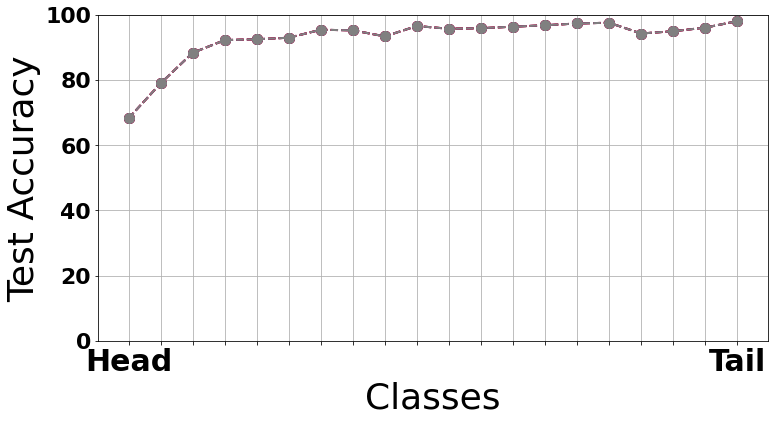

In [111]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
# probs = torch.nn.functional.sigmoid(AP.scores)
# get score distribution for each class
plt.figure(figsize=(8,6))
font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(12,6))

colormap=['blue', 'orange', 'red', 'purple', 'grey']
modelmap=['FC', 'GCN', 'AC', 'TE', 'SE']
leg =list()
for i,model in enumerate(models):
  scores, targets = score_per_model[i]
  x = class_di.keys()
  y = []
  for k, v in class_di.items():
      idx = label_li.index(k)
      # sort scores
      prob = scores[:, idx]
      label = targets[:,idx]
  #     conf = torch.nn.functional.sigmoid(prob)
      
      p1 = len(np.intersect1d(np.argwhere(prob>0), np.argwhere(label==1)))
      p0 = len(np.intersect1d(np.argwhere(prob<=0), np.argwhere(label!=1)))
      # print(100*(p1+p0)/len(prob))
      y.append(100*(p1+p0)/len(prob))
      # sort examples
  #     print(sm)
  #     con, indices = torch.sort(conf, dim=0, descending=True)
  #     print(k, sm[0], sm[-1])

  #     plt.hist(con, bins=10, alpha=0.5, label=k)
  a =ax.plot(x, y, color=colormap[i], marker='o', linestyle='dashed',
      linewidth=2, markersize=10, label=modelmap[i])
  # leg.append(a)
    # print(sorted, indices)

# plt.title('', size=36)
plt.xlabel("Classes", size=36)
classes = ["Head"] + [""]*18 + ["Tail"]
ax.set_xticklabels(classes,rotation=0, fontsize=30)
plt.ylabel("Test Accuracy", size=36)
plt.ylim([0,100])
# ax.legend(handles=leg)
ax.grid()

# plt.show()
plt.savefig('figures/VOC_classAccuracy-TC.pdf', dpi=600)

person
torch.Size([9904]) torch.Size([9904])
ECE:  0.43
car
torch.Size([9904]) torch.Size([9904])
ECE:  0.78
chair
torch.Size([9904]) torch.Size([9904])
ECE:  0.73
dog
torch.Size([9904]) torch.Size([9904])
ECE:  0.88
sofa
torch.Size([9904]) torch.Size([9904])
ECE:  0.87
cat
torch.Size([9904]) torch.Size([9904])
ECE:  0.92
bird
torch.Size([9904]) torch.Size([9904])
ECE:  0.93
horse
torch.Size([9904]) torch.Size([9904])
ECE:  0.92
train
torch.Size([9904]) torch.Size([9904])
ECE:  0.94
tvmonitor
torch.Size([9904]) torch.Size([9904])
ECE:  0.9
pottedplant
torch.Size([9904]) torch.Size([9904])
ECE:  0.85
bicycle
torch.Size([9904]) torch.Size([9904])
ECE:  0.92
diningtable
torch.Size([9904]) torch.Size([9904])
ECE:  0.87
bottle
torch.Size([9904]) torch.Size([9904])
ECE:  0.9
motorbike
torch.Size([9904]) torch.Size([9904])
ECE:  0.94
aeroplane
torch.Size([9904]) torch.Size([9904])
ECE:  0.95
bus
torch.Size([9904]) torch.Size([9904])
ECE:  0.95
boat
torch.Size([9904]) torch.Size([9904])
ECE:  

/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 576x216 with 0 Axes>

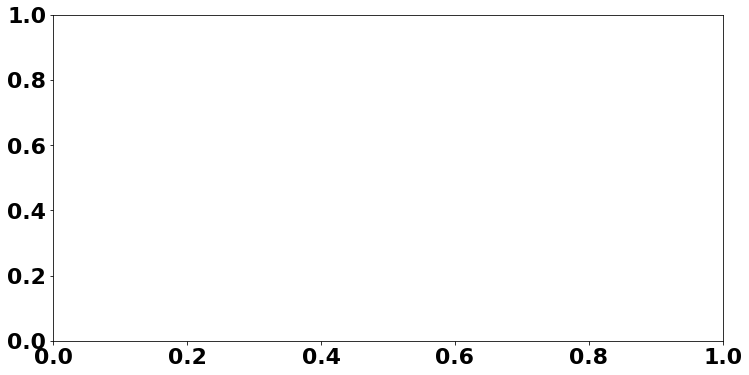

In [98]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
# probs = torch.nn.functional.sigmoid(AP.scores)
# get score distribution for each class
plt.figure(figsize=(8,3))
font = {'family' : 'Verdana','weight' : 'bold', 'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
x = [i*0.1 for i in range(10)]
y = []
conf = torch.nn.functional.sigmoid(AP.scores)
from collections import defaultdict
ECE = defaultdict(float)
for k, v in cls_ind.items():
  print(k)
  scores = AP.scores[:]
  label = AP.targets[:]
  # print(scores.shape, label.shape)
  idx = label_li.index(k)
  # print(idx)
  score = scores[:, idx]
  label = label[:, idx]
  conf =torch.nn.functional.sigmoid(score)
  print(score.shape, label.shape)
  N = len(label)
  
  #get Acc[b], Conf[b], n[b]
  for t in range(10):
    cond = (conf<=(t+1)*0.1) & (conf>t*0.1)

    conf_b = conf[torch.argwhere(cond)]
    label_b = label[torch.argwhere(cond)]
    assert label_b.shape == conf_b.shape
    if label_b.shape[0] == 0:
      continue
    n_b = label_b.shape[0]
    predicted = np.where(conf_b > 0.5, 1, 0)
    assert predicted.shape == label_b.shape
    acc = np.count_nonzero(np.array(predicted)==np.array(label_b))/label_b.shape[0]
    diff = abs(acc - torch.mean(conf_b, dim=0))
    ECE[k] += (n_b/N*(diff)).item()
    
  print("ECE: ", round(ECE[k],2))


# 5. Class-wise CKA similarity

In [3]:
path_csv = './data/voc/files/VOC2007'
trainval_csv = os.path.join(path_csv, 'classification_trainval_LT.csv')

hi = pd.read_csv(trainval_csv)
hi=hi.iloc[:,1:]
print(hi.columns)
class_num = dict()
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)

nums=[]
from collections import defaultdict
cls_ind = defaultdict(list)

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  # di[col_name] = val.value_counts().to_dict()
  M = hi[hi[col_name].isin([1.0])].sum(axis=0)
  # print(M)
  cls_ind[col_name].extend(hi.index[hi[col_name].isin([1.0])].to_list())
  nums.append(M[col_name])
  class_num[col_name] = M[col_name]
class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
cls_ind = {k: v for k, v in sorted(cls_ind.items(), key=lambda item: len(item[1]), reverse=True)} #sorted

# train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl', LT=True)
test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')
# train_dataset = COCO2014('data/coco', phase='train', inp_name='data/coco/coco_glove_word2vec.pkl')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
test_dataset.transform = transforms.Compose([
                MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])
loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')
[dataset] read data/voc/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=20  number of images=4952


In [5]:
from models import *
model = resnet101(pretrained=True)

backbone = BaseResnet(model, 20)
backbone2 = BaseResnet(model, 20)
sa = TRANSCONV_clf(backbone, 20, 300, 'voc_lt_adj.pkl')
te2 = TRANSFORMER_ENCODER_2_clf(backbone, 20, 1, 16)
gcn = GCN_clf(backbone, 20, 300, None, 'voc_lt_adj.pkl')
se = SE(backbone, 20)
# gcn = GCN_clf(backbone, 20)
##LT
p1= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-1-16-0_resnet101_base_best.pth.tar'#freezed
p2 = 'checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_gcn_best.pth.tar'
p3 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_sa_best.pth.tar'
p4='/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_transformer_encoder-1-16-0_resnet101_transformer_encoder_best.pth.tar'##freeze
p5 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_freeze-4-4-0_resnet101_se_best.pth.tar'

p6 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_fixed~0-4-4-1_resnet101_base_best.pth.tar' #finetuned
##uniform
path = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-16-1-2_resnet101_base_best.pth.tar'##finetune
path2='/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_base-16-1-1_resnet101_base_best.pth.tar'##freeze

path3= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_freeze-4-4-0_resnet101_sa_best.pth.tar'#freeze
path4 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-2-1-1_resnet101_transformer_encoder_best.pth.tar'

model_li = []
for path, model in zip([p6, p2, p3, p4, p5], [backbone, gcn, sa, te2, se]):
  di = torch.load(path)
  model.load_state_dict(di['state_dict'])
  print(di['best_score'])
  model_li.append(model)

{'mAP': tensor(76.8668), 'OF1': 0.6734609557912133, 'CF1': 0.5584720102953683}
{'mAP': tensor(16.7493), 'OF1': 0.23363922566816264, 'CF1': 0.11790095247249723}
{'mAP': tensor(64.7172), 'OF1': 0.537910447761194, 'CF1': 0.4585621112656234}
{'mAP': tensor(73.5576), 'OF1': 0.6167736474571489, 'CF1': 0.5796746147754647}
{'mAP': tensor(9.4871), 'OF1': 0.3342580916351408, 'CF1': 0.09001902545260966}


In [21]:
## get dataset class-wise
cls_ind
def get_subset(idx):

  ss = torch.utils.data.Subset(test_dataset, indices=idx)
  return torch.utils.data.DataLoader(ss, batch_size=32)

from util import AveragePrecisionMeter
AP = AveragePrecisionMeter(difficult_examples=False)

pair = ('person', 'chair')
pair = ('chair', 'diningtable')
pair = ('pottedplant', 'train')
pair = ('dog', 'horse')
pair = ('cat', 'bus')
pair = ('pottedplant', 'chair')

class_ap = dict()
for k, v in cls_ind.items():
  if k == pair[0]:
    print("label: ", k)
    loader = get_subset(v)
    
    for i, (input, target) in tqdm(enumerate(loader)):
      img, path, inp = input
      target[target == 0] = 1
      target[target == -1] = 0
      feat_Var = torch.autograd.Variable(img).float().detach()
      
      # feature = model_li[3].features(feat_Var)
      # feature = feature.view(feature.size(0), -1)
      # # output = np.array(feature.detach())
      # output = np.array(model_li[3].blocks(feature).detach())

      feature = model_li[0].features(feat_Var)
      feature = feature.view(feature.size(0), -1)
      output = np.array(feature.detach())
      AP.add(output, target)
    Z1 = AP.scores
    AP = AveragePrecisionMeter(difficult_examples=False)
  if k == pair[1]:
    print("label: ", k)
    loader = get_subset(v)
    
    for i, (input, target) in tqdm(enumerate(loader)):
      img, path, inp = input
      target[target == 0] = 1
      target[target == -1] = 0
      feat_Var = torch.autograd.Variable(img).float().detach()
      
      # feature = model_li[3].features(feat_Var)
      # feature = feature.view(feature.size(0), -1)
      # # output = np.array(feature.detach())
      # output = np.array(model_li[3].blocks(feature).detach())

      feature = model_li[0].features(feat_Var)
      feature = feature.view(feature.size(0), -1)
      # feature = model_li[2](feat_Var, None)
      output = np.array(feature.detach())
      AP.add(output, target)
    Z2 = AP.scores 
    AP = AveragePrecisionMeter(difficult_examples=False)


label:  chair


14it [00:16,  1.14s/it]


label:  pottedplant


5it [00:04,  1.00it/s]


In [22]:
m = min(len(Z1), len(Z2))
print(m)
Z1_ = Z1[:m,:]
Z2_ = Z2[:m,:]

135


In [23]:
from CKA import CKA, CudaCKA
cka = CKA()

print(cka.linear_CKA(Z1_, Z2_))
print(cka.kernel_CKA(Z1_, Z2_))

0.3561856484213207
0.46657916845843894


# Visulizing t-SNE

In [77]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(Z)


/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [78]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [55]:
print(labels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


20


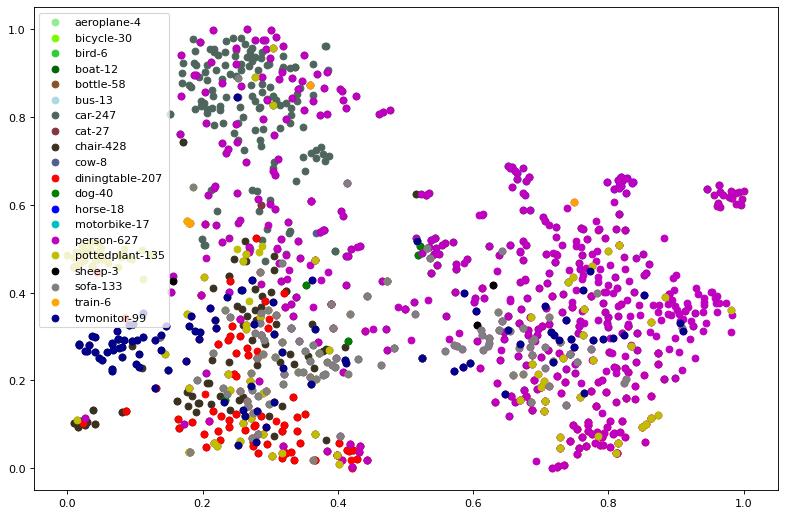

In [79]:
# initialize a matplotlib plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_subplot(111)
category_to_color = {0: 'lightgreen', 1: 'lawngreen', 2:'limegreen', 3: 'darkgreen'}
category_to_label = {0: 'A', 1:'B', 2:'C', 3:'D'}
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
nums=[4, 30, 6, 12, 58, 13, 247, 27, 428, 8, 207, 40, 18, 17, 627, 135, 3, 133, 6, 99]
colors = ['lightgreen', 'lawngreen', 'limegreen', 'darkgreen', '#875525','lightblue', '#4E655E', '#853541', '#3A3120', '#535D8E','r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey', 'orange', 'darkblue']
for i in range(20):
    category_to_color[i] = colors[i]
    category_to_label[i] = '{}-{}'.format(label_li[i],  str(nums[i]))
print(len(colors))
# for every class, we'll add a scatter plot separately
for category, color in category_to_color.items():
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l[category] == 1]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=category_to_label[category])

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

In [84]:
## check
import pandas as pd
coco_lt_path = "data/coco"
voc_lt_path = "data/voc/"
path_csv = './data/voc/files/VOC2007'
trainval_csv = os.path.join(path_csv, 'classification_trainval_LT.csv')
test_csv = os.path.join(path_csv, 'classification_test.csv')
hi = pd.read_csv(trainval_csv)
print(hi.columns)
print(hi.shape)
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)

hi=hi.iloc[:,1:]
di = dict()
adj = []
nums = []

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  if col_name == 'tvmonitor':
    M = hi[hi[col_name].isin([1.0])].sum(axis=0)
    print(M)

Index(['name', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')
(1058, 21)
aeroplane       0
bicycle         1
bird            0
boat            0
bottle          6
bus             0
car             1
cat             1
chair          73
cow             0
diningtable    13
dog             5
horse           0
motorbike       0
person         38
pottedplant    14
sheep           0
sofa           27
train           0
tvmonitor      99
dtype: int64
